<a href="https://colab.research.google.com/github/iamstarstuff/MScDataScienceThesis/blob/main/ML%20Models%20Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn-intelex
!pip install sklearn-genetic-opt[all]

In [2]:
import sklearnex
sklearnex.patch_sklearn()

# Getting the GPU info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

import tensorflow as tf
# Making sure the GPU is connected and will be used
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

gpus

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Tue Jul 18 12:10:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('https://github.com/iamstarstuff/MScDataScienceThesis/raw/main/Skyserver_SQL5_24_2023%2012_41_33%20PM.csv')

In [5]:
df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237660e+18,213.992460,-2.453992,17.92948,18.19919,18.66623,19.01955,19.31679,2379,301,3,32,4.543040e+18,STAR,0.000076,4035,55383,112
1,1.237660e+18,214.058474,-2.597317,18.79543,17.72650,17.31048,17.14916,17.10742,2379,301,3,32,1.031330e+18,STAR,0.000092,916,52378,30
2,1.237660e+18,214.551367,-2.504556,19.32994,18.36031,18.04727,17.91241,17.85185,2379,301,3,36,4.539760e+18,STAR,0.000496,4032,55333,463
3,1.237660e+18,215.094035,-2.431390,19.58494,19.71145,19.29750,19.19037,19.28850,2379,301,3,39,1.032490e+18,QSO,1.340945,917,52400,160
4,1.237660e+18,215.137407,-2.539874,19.12029,18.20783,17.91957,17.80769,17.77281,2379,301,3,40,1.032490e+18,STAR,-0.000352,917,52400,142


In [6]:
df.shape

(500000, 18)

In [7]:
highcorr = df[['u','g','r','i','z','redshift']].corr()

<Axes: >

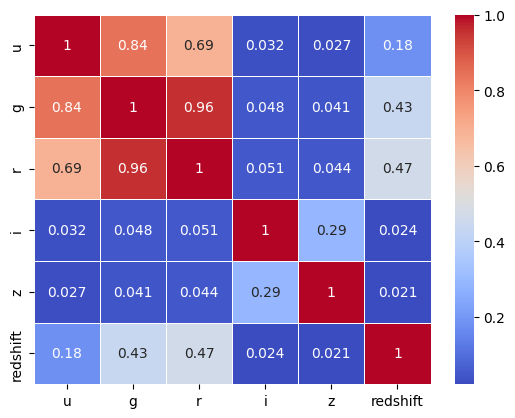

In [8]:
sns.heatmap(highcorr, annot=True, cmap='coolwarm',lw=0.5)

In [9]:
X = df[['u', 'g', 'r', 'i', 'z', 'redshift']]
y = df['class']

# SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create the classifier
clf = SVC()

# Train the classifier
clf.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = clf.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.98366


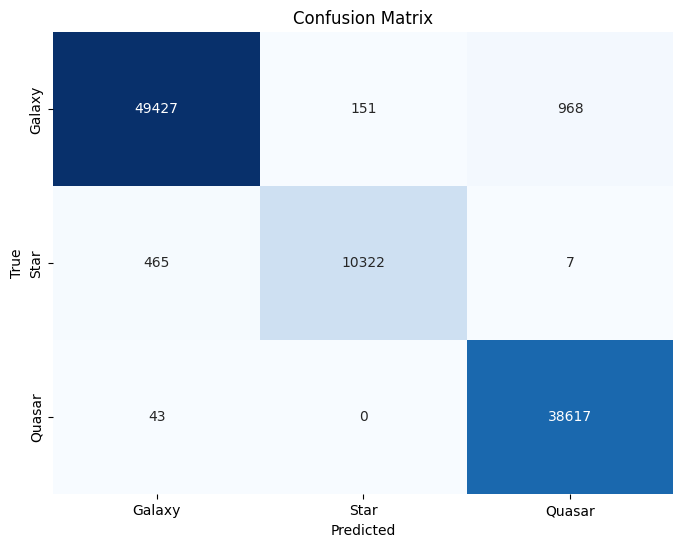

In [ ]:
y_pred = clf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Galaxy', 'Star', 'Quasar'],
            yticklabels=['Galaxy', 'Star', 'Quasar'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.6 MB/s eta 0:00:00
  Created wheel for databricks-cli: filename=databricks_cli-0.17.7-py3-none-any.whl size=143860 sha256=35c1ceb23bf020bff64f7d2ab2a6931e9960eb2d5c34946e2cff86a243e6d7d6
  Stored in directory: /root/.cache/pip/wheels/ae/63/93/5402c1a

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous,Categorical

# Load the dataset
df = pd.read_csv('https://github.com/iamstarstuff/MScDataScienceThesis/raw/main/Skyserver_SQL5_24_2023%2012_41_33%20PM.csv')

# Select features and target variable
X = df[['u', 'g', 'r', 'i', 'z', 'redshift']]
y = df['class']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'C': Continuous(1e-5, 1e10),  # Continuous range from 1e-5 to 1e10
    'gamma': Continuous(1e-15, 1e3),  # Continuous range from 1e-15 to 1e3
    'kernel': Categorical(['linear', 'rbf', 'poly'])
}

# Create the SVM classifier
svc = SVC()



# Create the genetic algorithm search object
ga_search = GASearchCV(estimator=svc, param_grid=param_grid, cv=3, verbose=True, population_size=50, generations=10)

# Perform the hyperparameter tuning
ga_search.fit(X_train, y_train)

# Get the best hyperparameters and accuracy score
best_params = ga_search.best_params_
best_score = ga_search.best_score_

# Train the classifier with the best hyperparameters
best_clf = SVC(C=best_params['C'], gamma=best_params['gamma'])
best_clf.fit(X_train, y_train)

# Predict the labels for the test set using the best classifier
y_pred = best_clf.predict(X_test)

# Calculate the accuracy of the best classifier
accuracy = accuracy_score(y_test, y_pred)

# Print the results
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_score)
print("Test Accuracy:", accuracy)


In [ ]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 13.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from deap import algorithms, base, creator, tools

# Load your dataset and split it into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Load the dataset
df = pd.read_csv('https://github.com/iamstarstuff/MScDataScienceThesis/raw/main/Skyserver_SQL5_24_2023%2012_41_33%20PM.csv')

# Select features and target variable
X = df[['u', 'g', 'r', 'i', 'z', 'redshift']]
y = df['class']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# Define the fitness function for the genetic algorithm
def evaluate_individual(individual):
    # Convert the values to corresponding hyperparameter values
    C = 2 ** np.round(individual[0])  # C ranges from 2^(-5) to 2^10
    gamma = 2 ** np.round(individual[1])  # gamma ranges from 2^(-15) to 2^(3)

    # Create the SVM classifier with the chosen hyperparameters
    clf = SVC(C=C, gamma=gamma)

    # Train the classifier
    clf.fit(X_train, y_train)

    # Predict the labels for the test set
    y_pred = clf.predict(X_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy,

# Define the optimization problem
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, -5, 10)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate_individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Set random seed for reproducibility
np.random.seed(42)

# Create an initial population of individuals
population = toolbox.population(n=50)

# Run the genetic algorithm optimization
population, logbook = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, verbose=False)

# Retrieve the best individual from the population
best_individual = tools.selBest(population, k=1)[0]

# Retrieve the best hyperparameters found by the genetic algorithm
best_hyperparameters = 2 ** np.round(best_individual)

# Create the SVM classifier with the best hyperparameters
best_clf = SVC(C=best_hyperparameters[0], gamma=best_hyperparameters[1])

# Train the classifier with the full training set
best_clf.fit(X_train, y_train)

# Predict the labels for the test set using the best classifier
y_pred = best_clf.predict(X_test)

# Calculate the accuracy of the best classifier
accuracy = accuracy_score(y_test, y_pred)
print("Best Accuracy:", accuracy)
print("Best Hyperparameters (C, gamma):", best_hyperparameters)


# Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier()

## Baseline
Performance of classifier using the default hyperparameter values

In [22]:
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.99153


## Genetic optimisation

In [12]:
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

param_grid = {'min_weight_fraction_leaf': Continuous(0.01, 0.5, distribution='log-uniform'),
              'bootstrap': Categorical([True, False]),
              'n_estimators': Integer(100, 300)}

cv = StratifiedKFold(n_splits=3, shuffle=True)

evolved_estimator = GASearchCV(estimator=clf,
                               cv=cv,
                               scoring='accuracy',
                               population_size=10,
                               generations=20,
                               tournament_size=3,
                               elitism=True,
                               crossover_probability=0.5,
                               mutation_probability=0.1,
                               param_grid=param_grid,
                               criteria='max',
                               algorithm='eaMuPlusLambda',
                               n_jobs=-1,
                               verbose=True,
                               keep_top_k=3)

In [13]:
evolved_estimator.fit(X_train,y_train)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.960188	0.0255098  	0.97853    	0.88561    
1  	16    	0.97467 	0.00265338 	0.97853    	0.971637   
2  	13    	0.977654	0.00193001 	0.979215   	0.973815   
3  	10    	0.978798	0.000453331	0.98       	0.97852    
4  	12    	0.979116	0.000293304	0.97948    	0.97853    
5  	11    	0.979597	0.000127312	0.97975    	0.979452   
6  	13    	0.979944	0.000444854	0.9808     	0.97948    
7  	14    	0.979823	0.000174241	0.980035   	0.97948    
8  	15    	0.979906	0.000126493	0.980035   	0.97967    
9  	17    	0.979879	0.000152567	0.980035   	0.979658   
10 	10    	0.980044	7.45747e-05	0.980198   	0.979882   
11 	14    	0.980015	9.38656e-05	0.980198   	0.979835   
12 	13    	0.980064	0.000105336	0.980198   	0.979835   
13 	13    	0.980333	0.000311336	0.980947   	0.980035   
14 	13    	0.980333	0.000311336	0.980947   	0.980035   
15 	15    	0.980276	0.000223818	0.980947   	0.980198   
16 	13    	0.980291	0.000222155	0.980947   	0.98

GASearchCV(crossover_probability=0.5,
           cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
           estimator=RandomForestClassifier(min_weight_fraction_leaf=0.01104661987579196,
                                            n_estimators=228),
           generations=20, keep_top_k=3, mutation_probability=0.1, n_jobs=-1,
           param_grid={'bootstrap': <sklearn_genetic.space.space.Categorical object at 0x7f1561bf3910>,
                       'min_weight_fraction_leaf': <sklearn_genetic.space.space.Continuous object at 0x7f1561bf1840>,
                       'n_estimators': <sklearn_genetic.space.space.Integer object at 0x7f1561d0fbb0>},
           population_size=10, return_train_score=True, scoring='accuracy')

In [14]:
y_predicy_ga = evolved_estimator.predict(X_test)
accuracy_score(y_test,y_predicy_ga)

0.97962

/usr/local/lib/python3.10/dist-packages/sklearn_genetic/plots.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=range(len(estimator)), y=fitness_history, markers=True, palette=palette)


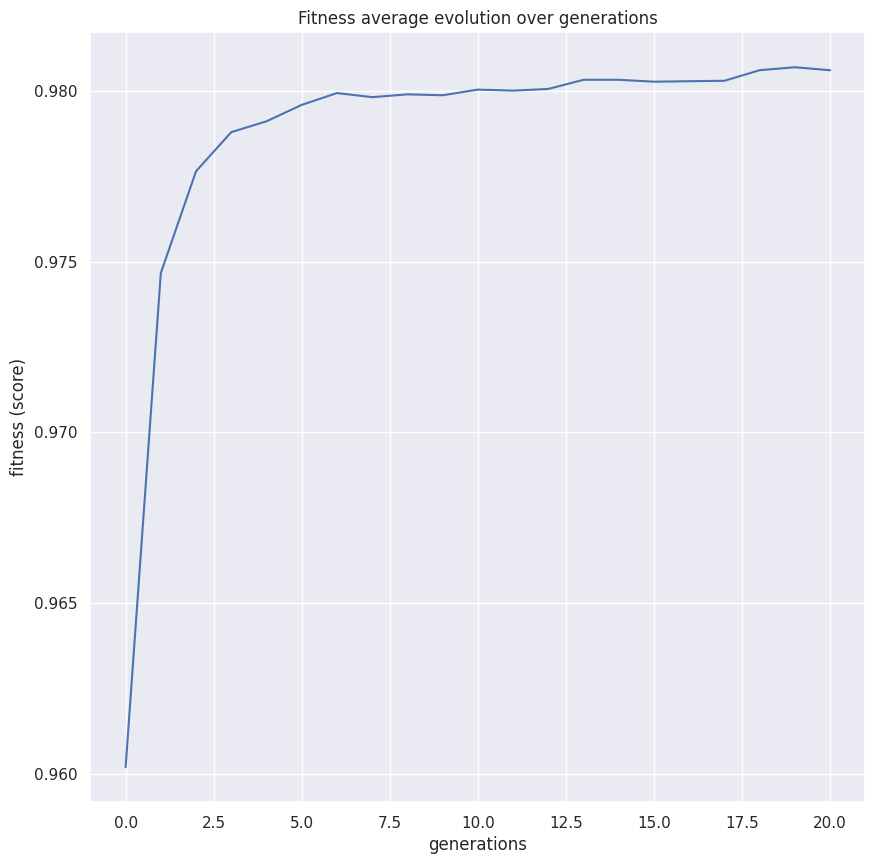

In [15]:
plot_fitness_evolution(evolved_estimator)
plt.show()

In [17]:
# Top 3 set of hyperparameter value combinations
pd.DataFrame(evolved_estimator.hof)

,0,1,2
min_weight_fraction_leaf,0.011047,0.011047,0.011047
bootstrap,True,False,True
n_estimators,228,228,228


# kNN